1. Вставить код для функций SoftMax, CELoss, accuracy в файл fn_utils.py
2. Вставить код для функций plot_cm, plot_history в файл vis_utils.py
3. Вставить код для классов DefectsDataset, MLP в основной файл
4. Проверить работоспособность кода
5. Провести серию расчетов с разными параметрами
6. Провести анализ результатов

In [19]:
import os
from IPython.display import clear_output

if 'train' not in os.listdir(os.curdir):
    !cd content
    !git clone https://github.com/chester-i-n/11MH-M.git
    !unzip /content/11MH-M/data.zip

    clear_output()

In [9]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import json
from itertools import product
from fn_utils import CELoss, accuracy
from train_utils import *
from vis_utils import *


# Constants

In [10]:
WORK_DIR = '/content' # Рабочая директория

CLASSES = ['norm', 'dis_1', 'dis_2', 'dis_both'] # Названия классов
USED_SENSORS = [0, 1, 2, 3, 4, 5]
SENSORS = [['temp', 'pos_x', 'pos_y', 'accel_x', 'accel_y', 'accel_z'][i] for i in USED_SENSORS] # Названия датчиков
STRIDES = 10 # Шаг для генерации примеров
N = 100 # Размер примеров
N_CL = len(CLASSES) # Количество классов
N_INP = N * len(SENSORS)

# Средние значения измерений по отдельным датчикам
MEAN = torch.tensor([ 1.55861268,  1.05951048,  0.67192477,
                     0.19552138,  0.06060946, -8.72093948], dtype=torch.float32)

# Стандартное отклонение измерений по отдельным датчикам
STD = torch.tensor([0.03424773, 0.00415722, 0.00476956,
                    0.20554204, 0.97876029, 0.50078193], dtype=torch.float32)

METRIC_NAME = 'accuracy' # Название метрики
METRIC = accuracy # Функция расчета метрики
CRITERION = CELoss # Функция расчета потерь
MODEL_NAME = 'MLP' # Название модели
BATCH_SIZE = 128 # Размер пакетов для обучения
EPOCHS = 100 # Максимальное количество эпох
EARLY_STOP_PATIENCE = 10 # Максимальное количество эпох без улучшения
DECAY = 1e-5 # Коэффициент регуляризации
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Выбор ресурсов для расчета
VERBOSE = True # Флаг для подробного вывода процесса обучения на экран

HYPS = [] # Списко гиперпараметров

hyps = {"learning_rate": [1e-3],
        "scheduler": ["step"],
        "n_layers": [3],
        "n_neurons": [32, 64],
        "dropout": [0, 0.2]}

for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})


# Create datasets

In [11]:
class DefectsDataset(Dataset):
    def __init__(self, path, n, stride):
        """ path - путь к папке с данными
            n - размер фрагментов измерений
            stride - шаг фрагментов
        """

        # ?

        self.inputs =
        self.targets =

        # ?


        # Добавляем нормализацию
        for i in USED_SENSORS:
            self.inputs[:, :, i] = (self.inputs[:, :, i] - MEAN[i]) / STD[i]

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

    def __len__(self):
        return len(self.targets)


# Create callback for train process

In [12]:
class EarlyStop():
    """Callback for early stop train process.

    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.

    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
        steps (int): Number of passed epoches.
        best_step (int): Number of best epoch.
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """

    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999

    def start(self, history, model):
        """Start and init callback.

        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
            model (Model): Training model.
        """

        self.history = history
        self.model = model

    def step(self):
        """Make a step of callback.

        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """

        self.steps += 1

        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps

        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False

    def stop(self):
        """Delete model from callback."""

        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.

    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.

    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
        steps (int): Number of passed epoches.
        best_step (int): Number of best epoch.
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """

    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999

    def start(self, history, model):
        """Start and init callback. Save first version of model.

        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
            model (Model): Training model
        """

        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)

    def step(self):
        """Make a step of callback.

        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """

        self.steps += 1

        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps

        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor,self.history[self.monitor][self.best_step]), False
        return None, False

    def stop(self):
        """Delete model from callback."""

        self.model = None
        torch.cuda.empty_cache()

# Create model

In [13]:
def hidden_layer():
    """Функция для создания промежуточного слоя нейросети"""
    layer = nn.Sequential(
            *[nn.Dropout(0.1),
              nn.Linear(600, 600, bias=False),
              nn.BatchNorm1d(600),
              nn.ReLU(inplace=True)])
    return layer


class MLP(nn.Module):
    def __init__(self, n_inp, n_cl, n_layers, n_neurons, dropout):
        super(MLP, self).__init__()

        self.n = 3
        layers = []
        for i in range(2):
            layers.append(hidden_layer())

        self.layers = nn.Sequential(*layers)

        self.out = nn.Sequential(
            *[nn.Dropout(0.1),
              nn.Linear(600, 4, bias=False)])

    def forward(self, x):
        # Преобразуем вход к вектору
        x = torch.flatten(x, 1)
        if self.n < 2:
            out = self.out(x)
        else:
            out = self.layers(x)
            out = self.out(out)
        return out

# Train model

Train


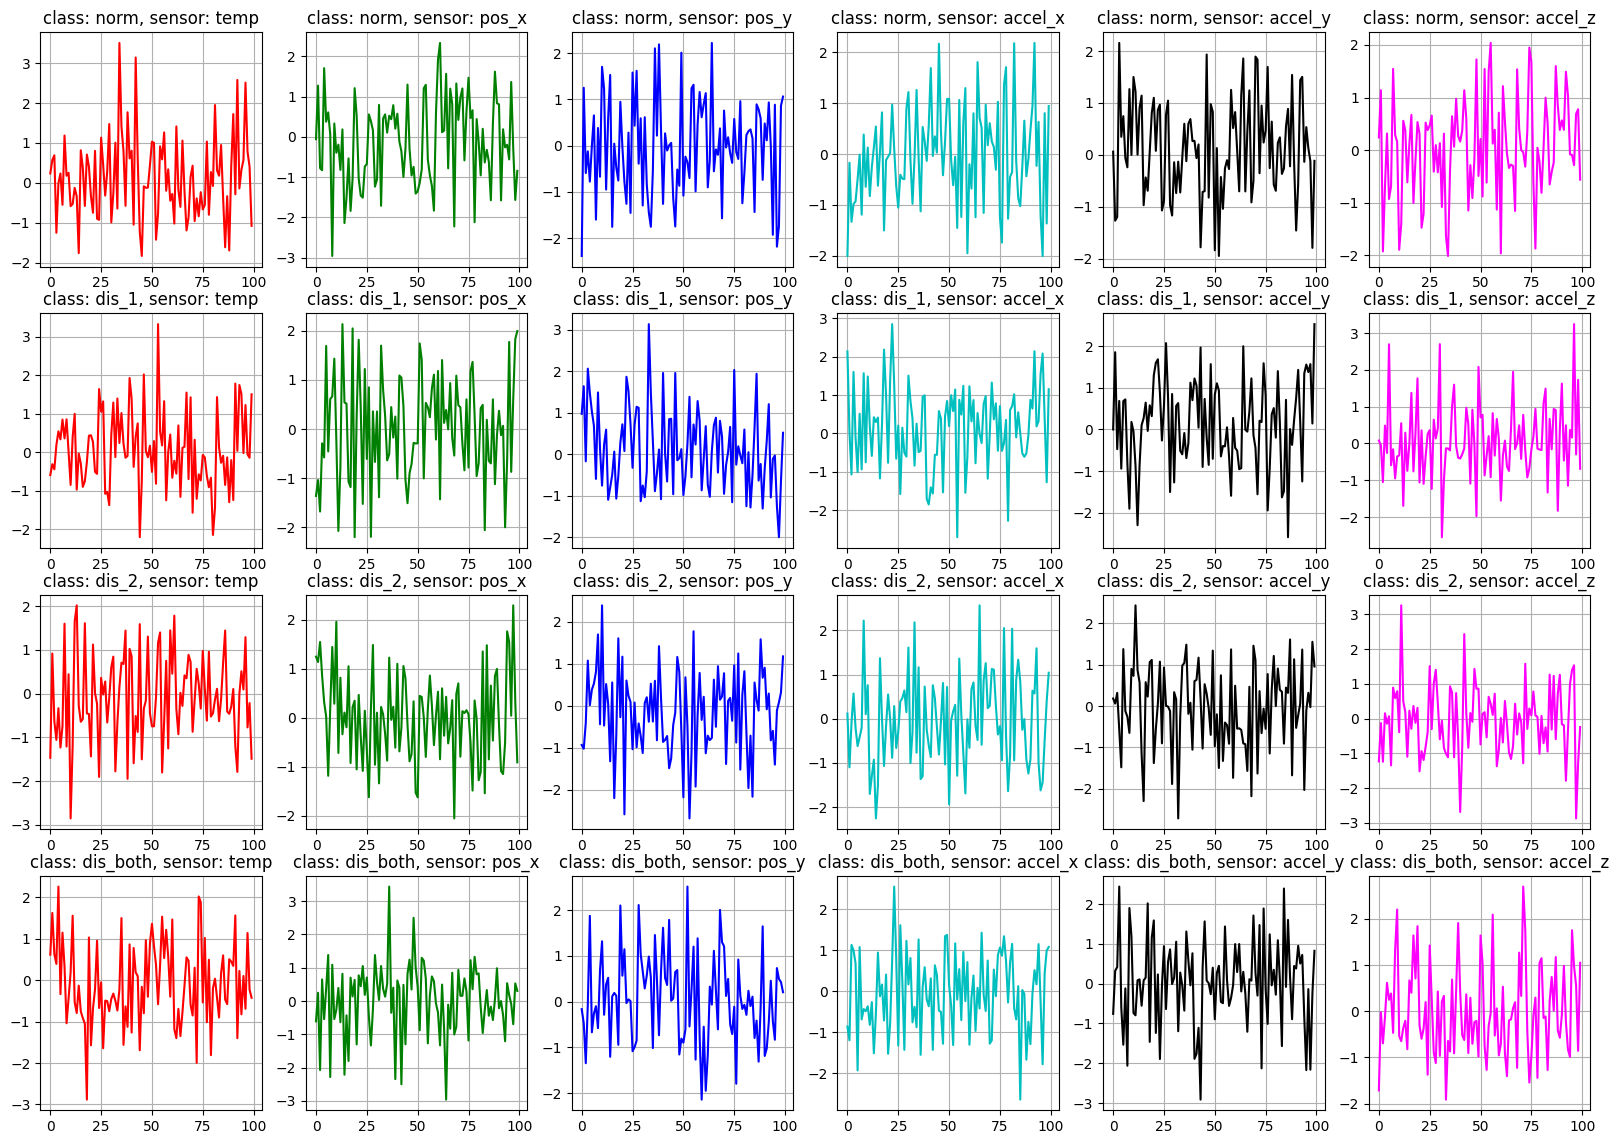

hyperparams: 
 learning_rate 0.001, scheduler step, n_layers 3, n_neurons 32, dropout 0


Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Best Val accuracy 0.2400
hyperparams: 
 learning_rate 0.001, scheduler step, n_layers 3, n_neurons 32, dropout 0.2


Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Best Val accuracy 0.1800
hyperparams: 
 learning_rate 0.001, scheduler step, n_layers 3, n_neurons 64, dropout 0


Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Best Val accuracy 0.3100
hyperparams: 
 learning_rate 0.001, scheduler step, n_layers 3, n_neurons 64, dropout 0.2


Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Best Val accuracy 0.2900
Best val accuracy: 0.3100, best hyperparams: learning_rate: 0.001, scheduler: step, n_layers: 3, n_neurons: 64, dropout: 0


<ipython-input-14-3a2023ba76f4>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


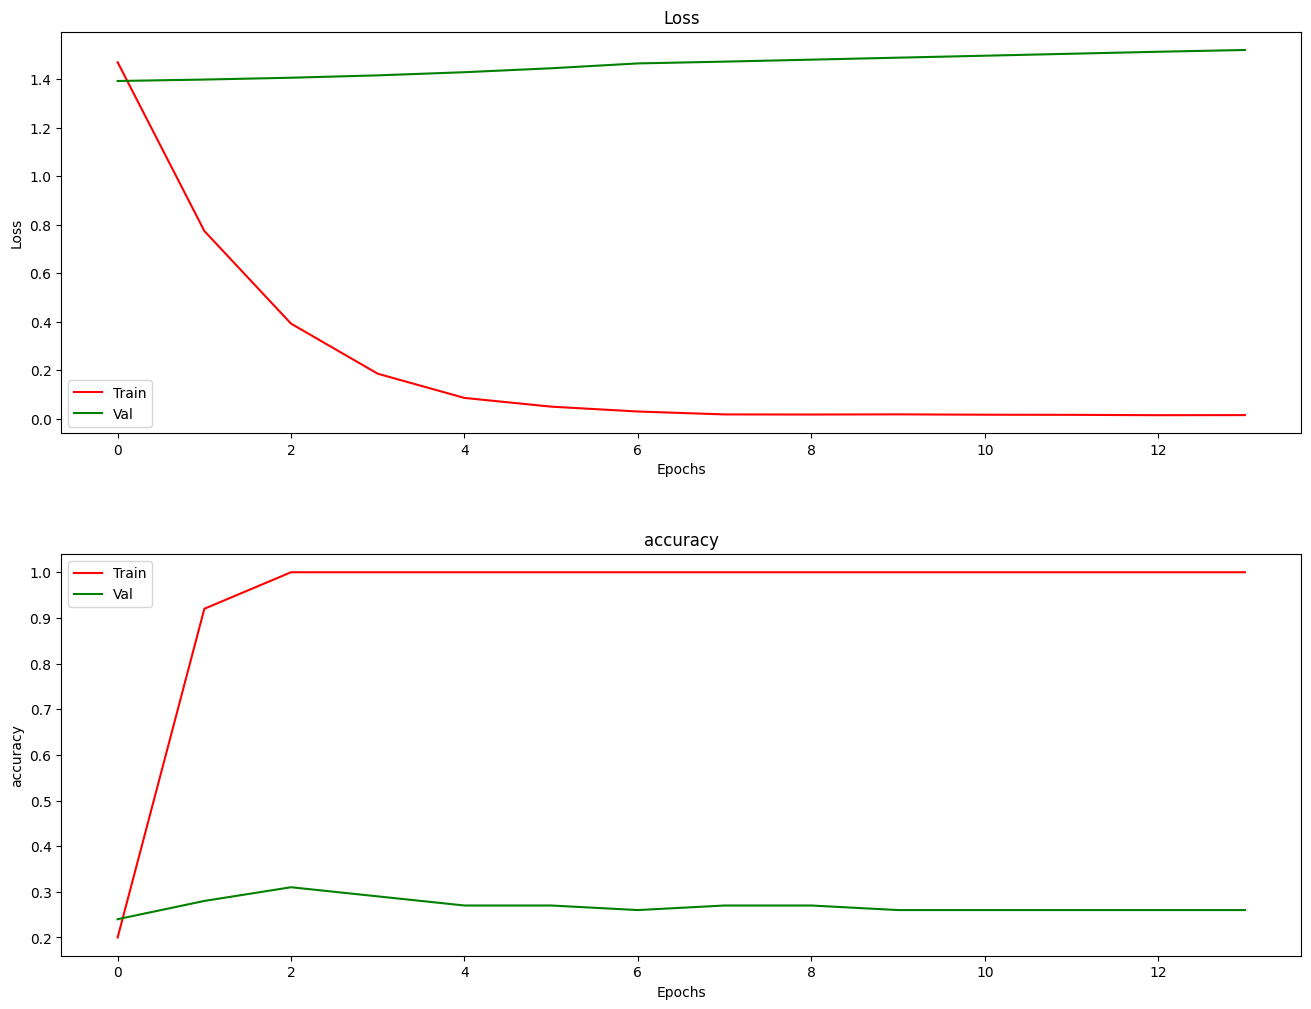

Train loss: 0.7984, Train accuracy: 1.0000


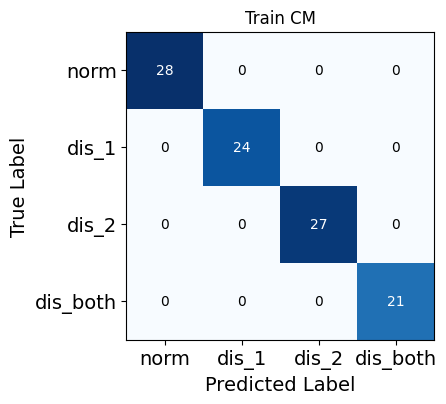

Val loss: 1.4052, Val accuracy: 0.3100


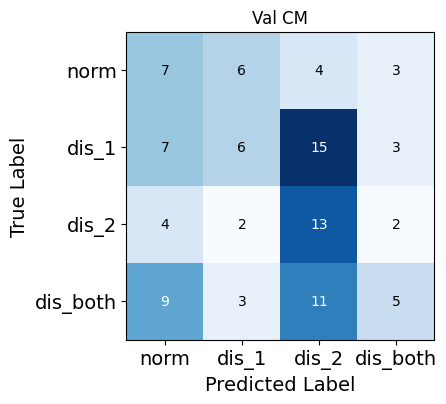

Test loss: 1.3948, Test accuracy: 0.2500


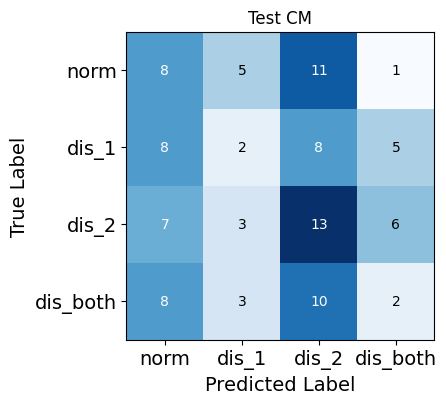

MLP(
  (layers): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): Linear(in_features=600, out_features=600, bias=False)
      (2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): Linear(in_features=600, out_features=600, bias=False)
      (2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
  )
  (out): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=600, out_features=4, bias=False)
  )
)


In [14]:
os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

train_dataset = DefectsDataset(f'{WORK_DIR}/train', N, STRIDES)
val_dataset = DefectsDataset(f'{WORK_DIR}/val', N, STRIDES)
test_dataset = DefectsDataset(f'{WORK_DIR}/test', N, STRIDES)

show_samples(train_dataset, SENSORS, CLASSES, 'Train')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

run_record = {}
for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp))

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}')

    callbacks = [EarlyStop(f'Val {METRIC_NAME}', EARLY_STOP_PATIENCE, 'max'),
                 SaveBest(f'Val {METRIC_NAME}', model_path, 'max')]

    model = MLP(n_inp=N_INP, n_cl=N_CL,
                n_layers=hyp['n_layers'], n_neurons=hyp['n_neurons'],
                dropout=hyp['dropout'])

    model = model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=hyp["learning_rate"],
                           weight_decay=DECAY)

    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  mode='min',
                                                                  patience=5,
                                                                  min_lr=1e-6,
                                                                  factor=0.1)
    else:
        lr_scheduler = None

    history = train_classifier(model, train_loader, val_loader, optimizer,
                               CRITERION, verbose=VERBOSE, metric_fn=METRIC,
                               metric_name=METRIC_NAME, epochs=EPOCHS,
                               print_every=10, callbacks=callbacks,
                               lr_scheduler=lr_scheduler)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}

    with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
        json.dump(run_record, fp)

    print(f"Best Val {METRIC_NAME} %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric < train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best val {METRIC_NAME}: %4.4f, best hyperparams: %s" % (best_val_metric,
                                                                best_hyp))

model = MLP(n_inp=N_INP, n_cl=N_CL,
            n_layers=best_hyperparams['n_layers'], n_neurons=best_hyperparams['n_neurons'],
            dropout=best_hyperparams['dropout'])

model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

plot_history(best_run['history'])

with torch.no_grad():
    targets, predictions = predict(model, train_loader)
    loss, metric = evaluate_model(targets, predictions, CRITERION, METRIC)
    print("Train loss: {:.4f}, Train {}: {:.4f}".format(loss, METRIC_NAME, metric))
    plot_cm(targets, predictions, 'Train', CLASSES)

    targets, predictions = predict(model, val_loader)
    loss, metric = evaluate_model(targets, predictions, CRITERION, METRIC)
    print("Val loss: {:.4f}, Val {}: {:.4f}".format(loss, METRIC_NAME, metric))
    plot_cm(targets, predictions, 'Val', CLASSES)

    targets, predictions = predict(model, test_loader)
    loss, metric = evaluate_model(targets, predictions, CRITERION, METRIC)
    print("Test loss: {:.4f}, Test {}: {:.4f}".format(loss, METRIC_NAME, metric))
    plot_cm(targets, predictions, 'Test', CLASSES)

print(model)

train_loader = None
val_loader = None
test_loader = None

train_dataset = None
val_dataset = None